In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)
from mpl_toolkits.mplot3d import Axes3D

## Question 2

In [2]:
# load the data
df = pd.read_csv('Adops & Data Scientist Sample Data - Q2 Regression.csv',header= None)
df.columns = ['A','B','C']

## EAD and Data Cleaning

In [3]:
# Check if there is any missing values
df.isnull().values.any()

False

There is no missing value in this data set. Next, let's look at the distribution of data.

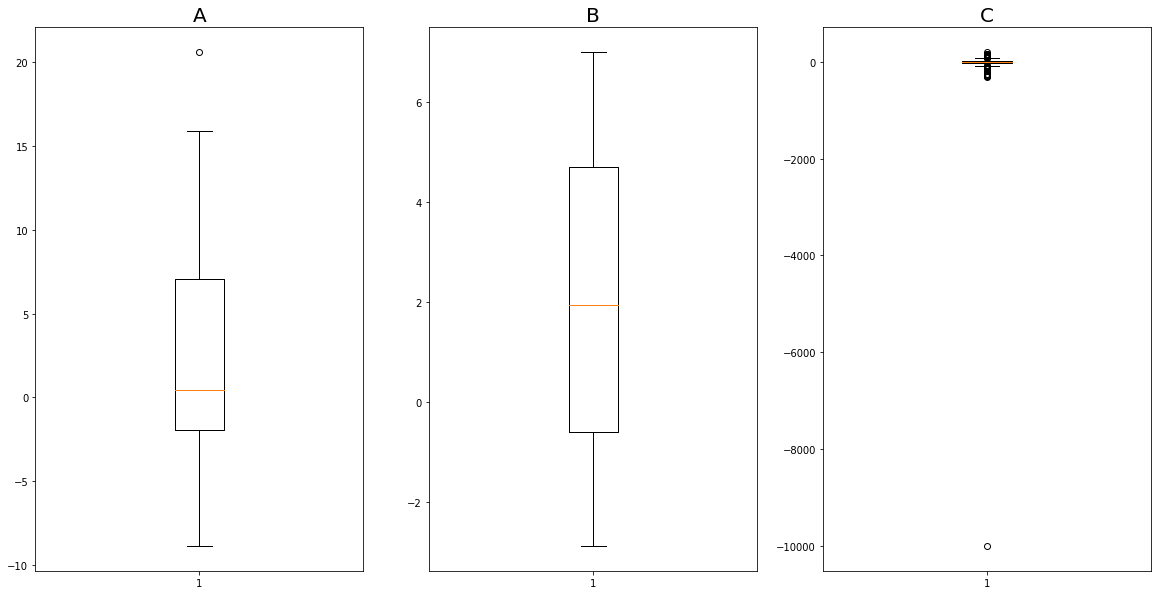

In [4]:
# Visualization - distribution
plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.boxplot(df.A)
plt.title('A',fontsize=20)
plt.subplot(1, 3, 2)
plt.boxplot(df.B)
plt.title('B',fontsize=20)
plt.subplot(1, 3, 3)
plt.boxplot(df.C)
plt.title('C',fontsize=20)
plt.show()

There is an outlier in C, I will take a look at it in 3D plot.

Text(0.5, 0, '$C$')

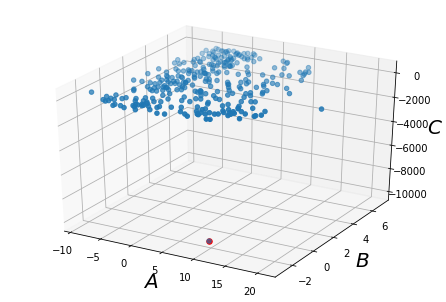

In [6]:
# Visualization - 3D
A = df.A.values
B = df.B.values
C = df.C.values

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(A,B,C)
ax.scatter(A[200],B[200],C[200],color = "red", s = 30)
ax.set_xlabel('$A$', fontsize=20)
ax.set_ylabel('$B$', fontsize=20)
ax.set_zlabel('$C$', fontsize=20)

As is shown in the plot above, there is an obvious outlier, which is marked as red. Linear regression models are sensitive towards outliers, thus, I decided to remove that row.

In [7]:
# remove outliers
df_clean = df[df.C != df.C.min()]

After removing the outlier, data visualization will become

Text(0.5, 0, '$C$')

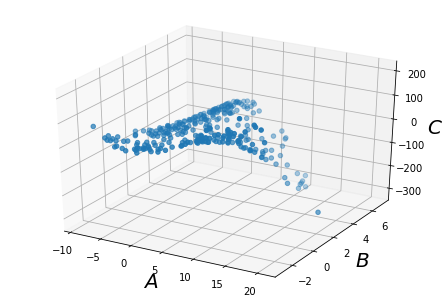

In [8]:
A = df_clean.A.values
B = df_clean.B.values
C = df_clean.C.values

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(A,B,C)
ax.set_xlabel('$A$', fontsize=20)
ax.set_ylabel('$B$', fontsize=20)
ax.set_zlabel('$C$', fontsize=20)

## Building Linear Regression models

we want to build a regression model which explains column C by a function of A and B. That model can be represented as below 

$$C = \beta_0 + \beta_1 A + \beta_2 B$$

<center>Or</center> 

$$Y = \beta ^ T X$$

<center>where</center> 

$$Y = C$$

$$\beta = [\beta_0, \beta_1, \beta_2]$$

<center>and</center>

$$X = [1, A, B]$$

Thus, the cost function we want to minimize will be

$$J(\beta) = \frac{1}{2n} \sum_{i=1}^n(\beta^T x^{(i)}-y^{(i)})^2$$ 

where $\beta^T x^{(i)}$ is the estimated y.

My goal is to find the optimal $\beta$ by minimizing the cost function. And gradient Descent is the optimization algorithm I used. Gradient Descent includes the following steps:

1. step 1: Initialize all $\beta$ with the value 0.

2. step 2: iteratively update $\beta_i$ with $\beta_i - \alpha \frac{\partial}{\partial\beta_i}J(\beta)$. Until it converges. where $\alpha$ is the learning rate, we choose 0.01 in this case.

Thus, the implementation will be:

In [9]:
def costFunction(X,y,beta):
    """
    compute cost function J.
    
    Parameters
    ----------
    X : array_like
        explanatory variables
    y: array_like
        response variable
    beta: list
        a list of coefficient
    
    Return
    ------
    J: float
        return the cost value
    """
    squared_residuals = np.power((X@beta.T-y),2)
    sum_squared_residuals = np.sum(squared_residuals)
    n = len(X)
    J = sum_squared_residuals/(2*n)
    return J

def gradientDescent(X, y, beta, n, alpha):
    """
    using gradient descent to minimize cost function.
    
    Parameters
    ----------
    X : array_like
        explanatory variables
    y: array_like
        response variable
    beta: array_like
        a list of coefficient
    n: int
        number of iterations
    alpha: float
        learning rate
    
    Return
    ------
    beta: array_like
        updated coefficient
    cost: array_like
        cost history
    """
    cost = np.zeros(n) # initial costs are 0
    for i in range(n):
        beta = beta - (alpha/len(X)) * np.sum(X * (X @ beta.T - y), axis = 0) # iteratively update beta
        cost[i] = costFunction(X, y, beta) # update cost 
    return beta, cost

In [10]:
# Create matrices 
X = df_clean.iloc[:,0:2] # get A and B
ones = np.ones([X.shape[0],1]) # constant
X = np.concatenate((ones,X),axis=1) # combine constant with explanatory variables

y = df_clean.iloc[:,2:3].values # get C
beta = np.zeros([1,3]) # initialize betas with 0

# set hyper_parameters
alpha = 0.01 # learning rate
n = 1000 # number of iterations

In [11]:
b, cost = gradientDescent(X, y , beta, n, alpha)
print(b)

[[ 25.62827002  -1.36092271 -15.20575852]]


Text(0, 0.5, 'Cost')

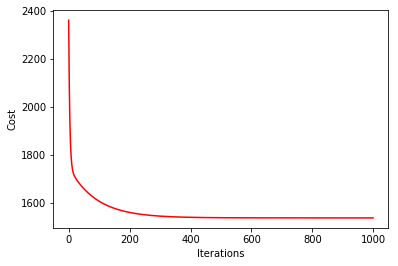

In [12]:
fig, ax = plt.subplots()
ax.plot(np.arange(n),cost, 'r')
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  

The above plot indicates a decreasing trend in cost with increasing number of iterations. The model converges after around 300 iterations.

### Evaluations

I use RMSE and $R^2$ score to evaluate the model.

In [13]:
def rmse(y, y_pred):
    """
    compute root-mean-square error
    
    Parameters
    ----------
    y: array_like
        actual response variable
    y_pred: array_like
        estimated y
    
    Return
    ------
    rmse: float
        root-mean-square error
    """
    rmse = np.sqrt(sum((y - y_pred) ** 2) / len(y))
    return rmse.item()

def r2_score(y, y_pred):
    """
    compute R squared score
    
    Parameters
    ----------
    y: array_like
        actual response variable
    y_pred: array_like
        estimated y
    
    Return
    ------
    r2: float
        r squared score
    """
    mean_y = np.mean(y)
    sst = sum((y - mean_y) ** 2)
    sse = sum((y - y_pred) ** 2)
    r2 = 1 - (sse / sst)
    return r2.item()

In [14]:
y_pred = X.dot(b.T) # get estimated y
RMSE = rmse(y,y_pred)
print('RMSE is',RMSE)
r2 = r2_score(y,y_pred)
print('R2 score is',r2)

RMSE is 55.42734296679078
R2 score is 0.3940209976851361


## improvement

Also notice that from the data visualization at begining, I noticed that data A is not a flat line, which suggests that polynomial terms might be needed. Thus, I decided to add a quadratic term $A^2$ and run the model again.

Also notice that A is in the range [-10,20]. After taking squared, that values can be relatively high. Thus, we will standardize A first.

In [15]:
# Create matrices 
X = df_clean.iloc[:,0:2] # get A and B
X['A'] = (X['A'] - X['A'].mean())/(X['A'].std()) # standardize
X['A2'] = X['A']**2 # add quadratic term
ones = np.ones([X.shape[0],1]) # constant
X = np.concatenate((ones,X),axis=1) # combine constant with explanatory variables

beta = np.zeros([1,4]) # initilize beta, change the size because add new variable

In [16]:
b, cost = gradientDescent(X, y , beta, n, alpha)
print(b)

[[ 31.70213486  -2.8089481  -15.43532625  -9.08358036]]


In [17]:
y_pred = X.dot(b.T) # get estimated y
RMSE = rmse(y,y_pred)
print('RMSE is',RMSE)
r2 = r2_score(y,y_pred)
print('R2 score is',r2)

RMSE is 54.51977152437136
R2 score is 0.4137032191080714


Both RMSE and $R^2$ improved after adding quadratic term.